We will use two functions to compare the efficiency of different queries:

**show_amount_of_data_scanned()** shows the amount of data the query uses.

**show_time_to_run()** prints how long it takes for the query to execute.

In [3]:
from google.cloud import bigquery
from time import time

client = bigquery.Client()

def show_amount_of_data_scanned(query):
    # dry_run lets us see how much data the query uses without running it

    dry_run_config = bigquery.QueryJobConfig(dry_run = True)
    query_job = client.query(query,job_config = dry_run_config)
    print('Data processed:{} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))

def show_time_to_run(query):
    time_config = bigquery.QueryJobConfig(use_query_cache = False)
    start = time()
    query_result = client.query(query, job_config = time_config).result()
    end = time()
    print('Time to run:{} seconds'.format(round(end-start, 3)))

Using Kaggle's public dataset BigQuery integration.


1) SELECT *  can be inefficient

In [4]:
star_query = "SELECT * FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(star_query)

basic_query = "SELECT size, binary FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(basic_query)

Data processed:2682.118 GB
Data processed:2.531 GB


2) Read less data

In [6]:
more_data_query = """
                  SELECT MIN(start_station_name) AS start_station_name,
                      MIN(end_station_name) AS end_station_name,
                      AVG(duration_sec) AS avg_duration_sec
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_id != end_station_id 
                  GROUP BY start_station_id, end_station_id
                  LIMIT 10
                  """
show_amount_of_data_scanned(more_data_query)

less_data_query = """
                  SELECT start_station_name,
                      end_station_name,
                      AVG(duration_sec) AS avg_duration_sec                  
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_name != end_station_name
                  GROUP BY start_station_name, end_station_name
                  LIMIT 10
                  """

show_amount_of_data_scanned(less_data_query)

Data processed:0.076 GB
Data processed:0.06 GB


3) Avoid N:N JOINS

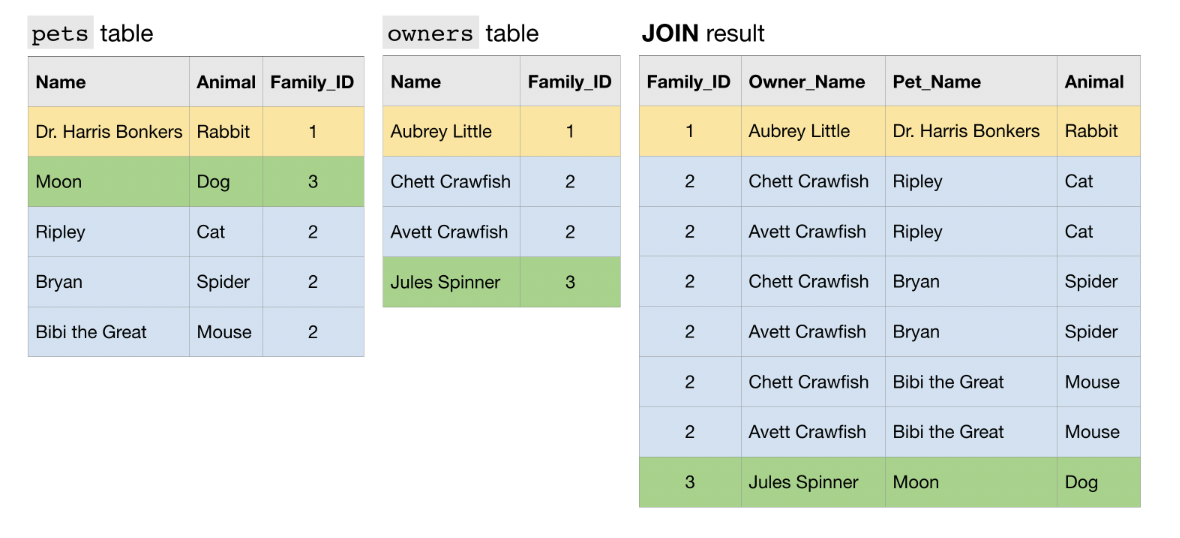

In [7]:
# 1） JOIN first, then using "WHERE" to filter
big_join_query = """
                 SELECT repo,
                     COUNT(DISTINCT c.committer.name) as num_committers,
                     COUNT(DISTINCT f.id) AS num_files
                 FROM `bigquery-public-data.github_repos.commits` AS c,
                     UNNEST(c.repo_name) AS repo
                 INNER JOIN `bigquery-public-data.github_repos.files` AS f
                     ON f.repo_name = repo
                 WHERE f.repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                 GROUP BY repo
                 ORDER BY repo
                 """
show_time_to_run(big_join_query)

# 2) Using "WHERE" to filter first, then JOIN
small_join_query = """
                   WITH commits AS
                   (
                   SELECT COUNT(DISTINCT committer.name) AS num_committers, repo
                   FROM `bigquery-public-data.github_repos.commits`,
                       UNNEST(repo_name) as repo
                   WHERE repo IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   ),
                   files AS 
                   (
                   SELECT COUNT(DISTINCT id) AS num_files, repo_name as repo
                   FROM `bigquery-public-data.github_repos.files`
                   WHERE repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   )
                   SELECT commits.repo, commits.num_committers, files.num_files
                   FROM commits 
                   INNER JOIN files
                       ON commits.repo = files.repo
                   ORDER BY repo
                   """

show_time_to_run(small_join_query)

Time to run:20.773 seconds
Time to run:3.276 seconds
